In [2]:
import pandas as pd
import rrcf
import datetime
import numpy as np
import sys 
sys.path.append('../utils/')
#sys.path.insert(0, '')
from helpers import nearest_after, optimal_fbeta, calculate_metrics, forest_to_dict
import seaborn as sns
import json

# Carga de datos

In [79]:
traffic_data = pd.read_csv('../data/cmex_mex_data/CMEX-TRAFFIC-2019.csv')
traffic_data.head()

,SC_ROUTER,DE_INTERFACE,NU_SPEED,NU_TRAFFIC_INPUT,NU_TRAFFIC_OUTPUT,DT_MEASURE_DATETIME,SC_INTERFACE_TYPE,DE_CUSTOMER_NAME,SD_ADMINISTRATIVE_NUMBER
0,CMEX-MEX-OCCRTRDW01,GigabitEthernet0/0/0,1024000000,10.947973,51.737784,2019-01-01 00:05:00,WAN,CMEX,407884
1,CMEX-MEX-OCCRTRDW01,GigabitEthernet0/0/0,1024000000,9.107212,51.606808,2019-01-01 00:10:00,WAN,CMEX,407884
2,CMEX-MEX-OCCRTRDW01,GigabitEthernet0/0/0,1024000000,7.813582,47.394608,2019-01-01 00:15:00,WAN,CMEX,407884
3,CMEX-MEX-OCCRTRDW01,GigabitEthernet0/0/0,1024000000,8.559426,52.318756,2019-01-01 00:20:00,WAN,CMEX,407884
4,CMEX-MEX-OCCRTRDW01,GigabitEthernet0/0/0,1024000000,7.580272,48.905152,2019-01-01 00:25:00,WAN,CMEX,407884


In [80]:
incidents_filtered = pd.read_csv("../data/cmex_mex_data/incidenciasCMEX-MEX.csv")
incidents_filtered.head()

,TICKET_ID,SERVICE_TYPE,SUBMIT_DATE,LAST_MODIFICATION_DATE,ASSIGNED_SUPPORT_COMPANY,REPORTED_DATE,REPORTED_SOURCE_ID,OPERATING_COMPANY_NAME,OPERATING_LE,CONTACT_COMPANY_NAME,...,OPERATIONAL_CATEGORIZATION_TIER_2,OPERATIONAL_CATEGORIZATION_TIER_3,CLOSURE_CATEGORIZATION_TIER_1,CLOSURE_CATEGORIZATION_TIER_2,CLOSURE_CATEGORIZATION_TIER_3,VENDOR_GROUP,INF2_HPD_OUTAGE_DURATION,CI_COUNTRY,ADMIN_NUMBER,INSTANCEID
0,INC000001638148,User Service Restoration,2019-03-21 03:46:51,2019-03-28 11:45:49,Telefonica,2019-03-21 03:46:46,12001.0,Telefonica Multinational Solutions LATAM,CEMEX,NaN,...,Total Isolation,Total Isolation,Provider,Local Loop,Notified scheduled work,NaN,5.0,Mexico,20160602-SITEMPLS-0000407884,IDGAA5V0F5V26APOPG8DPNRWGZW05S
1,INC000001750949,User Service Restoration,2019-06-08 01:25:21,2019-06-08 03:46:59,Telefonica,2019-06-08 01:24:38,12001.0,Telefonica Multinational Solutions LATAM,CEMEX,NaN,...,Total Isolation,Total Isolation,Telefonica,LOSS OF MANAGEMENT,FALSE ALARM,NaN,4.0,Mexico,20160602-SITEMPLS-0000407884,IDGAA5V0F5V26APSR0MJPRTUYI9DCI
2,INC000001751891,User Service Restoration,2019-06-09 01:49:34,2019-06-09 01:52:26,Telefonica,2019-06-09 01:49:25,12001.0,Telefonica Multinational Solutions LATAM,CEMEX,NaN,...,Total Isolation,Total Isolation,Provider,Local Loop,Restored automatically without intervention,NaN,2.0,Mexico,20160602-SITEMPLS-0000407884,IDGAA5V0F5V26APSTG4MPRVQO27ZCM
3,INC000001751917,User Service Restoration,2019-06-09 02:20:30,2019-06-09 02:23:44,Telefonica,2019-06-09 02:19:36,12001.0,Telefonica Multinational Solutions LATAM,CEMEX,NaN,...,Total Isolation,Total Isolation,Provider,Local Loop,Restored automatically without intervention,NaN,2.0,Mexico,20160602-SITEMPLS-0000407884,IDGAA5V0F5V26APSTHUGPRVSDW8A2G
4,INC000001752043,User Service Restoration,2019-06-09 03:56:16,2019-06-09 04:01:30,Telefonica,2019-06-09 03:56:07,12001.0,Telefonica Multinational Solutions LATAM,CEMEX,NaN,...,Total Isolation,Total Isolation,Provider,Local Loop,Restored automatically without intervention,NaN,5.0,Mexico,20160602-SITEMPLS-0000407884,IDGAA5V0F5V26APST2JSPRVW98826Y


# Fase de entrenamiento 

In [22]:
traffic_series = pd.Series(traffic_data.NU_TRAFFIC_INPUT.values, index = traffic_data.DT_MEASURE_DATETIME.values)
train_data = traffic_series['2019-01-01 00:00:00':'2019-03-31 23:55:00']
train_data = train_data[train_data != 0] 

In [23]:
num_trees = 50
tree_size = 512
train_index = train_data.index.values
forest = []
while len(forest) < num_trees:
    samples = np.random.choice(train_index, size = (num_trees, tree_size), replace = True)
    trees = [rrcf.RCTree(np.vstack(train_data.loc[sample].values), index_labels = sample) for sample in samples]
    forest.extend(trees) 

# Fase de scoring 

In [ ]:
test_data = traffic_series['2019-07-01 00:00:00':'2019-07-31 23:55:00']
codisp_no_shingle = pd.Series(0, index = test_data.index.values)

for next_index,next_point in test_data.items():
    for tree in forest:
        tree.insert_point(next_point, index=next_index)
        codisp_no_shingle[next_index] += tree.codisp(next_index)
        tree.forget_point(next_index)
avg_codisp_no_shingle = codisp_no_shingle/num_trees 

In [ ]:
avg_codisp_no_shingle.name = 'Anomaly score'
avg_codisp_no_shingle = avg_codisp_no_shingle.to_frame()
avg_codisp_no_shingle.reset_index(inplace=True)
avg_codisp_no_shingle.rename(columns={'index':'Date'}, inplace=True)
avg_codisp_no_shingle.describe()

In [ ]:
# Se puede guardar para su posterior uso
#avg_codisp_no_shingle.to_csv('../data/cmex_mex_data/cmex_anomaly_score_jul.csv', index = False)

# Fase de optimización del threshold

In [81]:
# Se podrían cargar desde un fichero las anomaly_scores necesarias
avg_codisp_no_shingle = pd.read_csv('../data/cmex_mex_data/cmex_anomaly_score_jul.csv')

In [82]:
# Nos quedamos con las fechas de test y transformamos a tipo datetime
traffic_data_test = traffic_data[(traffic_data['DT_MEASURE_DATETIME'] >= '2019-07-01 00:00:00') & (traffic_data['DT_MEASURE_DATETIME'] <= '2019-07-31 23:55:00')].copy()
traffic_dates_test = traffic_data_test.DT_MEASURE_DATETIME.values
traffic_dates_test = [datetime.datetime.strptime(date, '%Y-%m-%d %H:%M:%S') for date in traffic_dates_test]

incidents_filtered.sort_values(by = 'SUBMIT_DATE', inplace = True)
submit_dates_test = list(filter(lambda x: (str(x) > '2019-07-01 00:00:00' and str(x) < '2019-07-31 23:55:00'), incidents_filtered.SUBMIT_DATE.values))
resolved_dates_test = list(filter(lambda x: (str(x) > '2019-07-01 00:00:00' and str(x) < '2019-07-31 23:55:00'), incidents_filtered.LAST_RESOLVED_DATE.values))

mapped_submit_dates = [nearest_after(traffic_dates_test, submit_date) for submit_date in submit_dates_test]
mapped_resolved_dates = [nearest_after(traffic_dates_test, resolved_date) for resolved_date in resolved_dates_test]

# Eliminamos la primera resolved date, que no se corresponde a indicencias de julio
mapped_resolved_dates.pop(0)

# Se calculan las diferencias entre submit_dates y last_resolved_dates
differences_resolved_submit = [np.ceil((datetime.datetime.strptime(mapped_resolved_dates[i], '%Y-%m-%d %H:%M:%S') - datetime.datetime.strptime(mapped_submit_dates[i], '%Y-%m-%d %H:%M:%S')).total_seconds()/60/5) for i in range(len(mapped_resolved_dates))] # Diferencia en nº de intervalos de 5 min.

traffic_data_test['INCIDENT'] = 0.0
traffic_data_test.loc[traffic_data['DT_MEASURE_DATETIME'].isin(mapped_submit_dates), 'INCIDENT'] = 1.0
incidents = traffic_data_test.INCIDENT.values

anomaly_scores_50 = avg_codisp_no_shingle['Anomaly score'].values


In [14]:
prev_points = 2 
initial_threshold = 0
last_threshold = 250
beta_value = 2
num_incidents = len(mapped_resolved_dates)

best_threshold = optimal_fbeta(anomaly_scores_50, incidents, prev_points, differences_resolved_submit, initial_threshold, last_threshold, beta_value, num_incidents)
fp, fn, tp, recall, precision, f2_score = calculate_metrics(anomaly_scores_50, incidents, prev_points, best_threshold, differences_resolved_submit, beta_value, num_incidents)

In [15]:
print('El threshold óptimo es: {}'.format(best_threshold))
print('El número de alarmas es: {}'.format(fp))
print('El número incidencias no captadas es: {}'.format(fn))
print('El número de incidencias captadas es: {}'.format(tp))
print('La precisión es {} y el recall {}'.format(precision, recall))
print('La f2_score alcanzada es: {}'.format(f2_score))

El threshold óptimo es: 101.5
El número de alarmas es: 77
El número incidencias no captadas es: 4
El número de incidencias captadas es: 27
La precisión es 0.259615384615 y el recall 0.870967741935
La f2_score alcanzada es: 0.592105263158


# Threshold estadístico

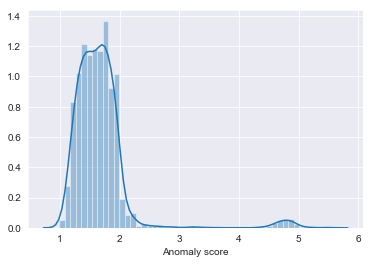

In [10]:
sns.set_style("darkgrid")
ax = sns.distplot(np.log(avg_codisp_no_shingle['Anomaly score']), label = "Anomaly Score")
ax

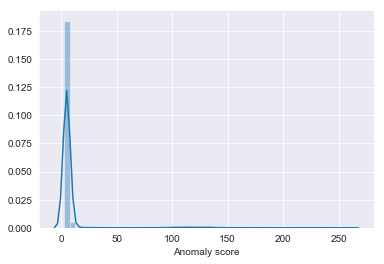

In [11]:
sns.set_style("darkgrid")
ax = sns.distplot(avg_codisp_no_shingle['Anomaly score'], label = "Anomaly Score")
ax

In [12]:
stat_threshold = avg_codisp_no_shingle["Anomaly score"].quantile(.99)
stat_threshold

121.50179999999972

In [24]:
# Creamos un archivo json donde guardamos los thresholds y el forest utilizado
forest_dict = forest_to_dict(forest) 
forest_dict["incident_threshold"] = best_threshold
forest_dict["statistic_threshold"] = stat_threshold
with open('../data/cmex_mex_data/CMEX-MEX-OCCRTRDW01_GigabitEthernet000_input.json', 'w') as output_file:
    json.dump(forest_dict, output_file)

# Create Alarms with anomaly score and traffic associated

In [13]:
best_threshold

101.5

In [14]:
stat_threshold

121.50179999999972

In [35]:
avg_codisp_no_shingle["best_alarm"] = 0.0
avg_codisp_no_shingle["stat_alarm"] = 0.0
avg_codisp_no_shingle.loc[avg_codisp_no_shingle["Anomaly score"] > best_threshold, "best_alarm"] = 1.0
avg_codisp_no_shingle.loc[avg_codisp_no_shingle["Anomaly score"] > stat_threshold, "stat_alarm"] = 1.0

In [20]:
avg_codisp_no_shingle.best_alarm.sum()

169.0

In [21]:
avg_codisp_no_shingle.stat_alarm.sum()

90.0

In [36]:
#avg_codisp_no_shingle.to_csv('../data/cmex_mex_data/cmex_anomaly_score_with_alarms.csv', index = False)

In [49]:
num_incidentes_july = incidents_filtered.loc[(incidents_filtered["SUBMIT_DATE"] >= "2019-07-01 00:00:00") & (incidents_filtered["SUBMIT_DATE"] <= "2019-07-31 23:30:00")].shape[0]
best_alarms = avg_codisp_no_shingle.best_alarm.sum()
print("Se ha lanzado {} alarmas, para {} incidencias registradas en el mes de Julio de 2019.".format(int(best_alarms), num_incidentes_july))

Se ha lanzado 169 alarmas, para 31 incidencias registradas en el mes de Julio de 2019.


In [50]:
just_alarms = avg_codisp_no_shingle.loc[avg_codisp_no_shingle["best_alarm"] == 1.0]
just_alarms.shape

(169, 4)

In [51]:
#just_alarms.to_csv('../data/cmex_mex_data/cmex_best_alarms.csv', index = False)

In [57]:
traffic_data_date = traffic_data[["DT_MEASURE_DATETIME", "NU_TRAFFIC_INPUT"]]
traffic_alarms = just_alarms.merge(traffic_data_date, how = "left", left_on = "Date", right_on = "DT_MEASURE_DATETIME")
traffic_alarms = traffic_alarms[["Date", "NU_TRAFFIC_INPUT", "best_alarm", "Anomaly score"]]
traffic_alarms.shape

(169, 4)

In [58]:
traffic_alarms

,Date,NU_TRAFFIC_INPUT,best_alarm,Anomaly score
0,2019-07-01 00:00:00,0.000000,1.0,124.72
1,2019-07-01 18:35:00,0.000000,1.0,106.38
2,2019-07-01 18:40:00,0.000000,1.0,139.84
3,2019-07-01 18:45:00,0.000000,1.0,129.94
4,2019-07-01 18:55:00,0.000000,1.0,122.68
5,2019-07-01 19:00:00,0.000000,1.0,113.34
6,2019-07-01 19:05:00,0.000000,1.0,115.34
7,2019-07-01 19:10:00,0.000000,1.0,117.90
8,2019-07-01 19:20:00,0.000000,1.0,129.38
9,2019-07-01 19:25:00,0.000000,1.0,113.70


In [60]:
traffic_data.NU_TRAFFIC_INPUT.describe()

count    105119.000000
mean         46.978817
std          33.098635
min           0.000000
25%          21.402983
50%          33.928692
75%          69.920440
max         252.009296
Name: NU_TRAFFIC_INPUT, dtype: float64

In [77]:
just_alarms = pd.read_csv('../data/cmex_mex_data/cmex_anomaly_score_with_alarms.csv')
just_alarms.head()

,Date,Anomaly score,best_alarm,stat_alarm
0,2019-07-01 00:00:00,124.72,1.0,1.0
1,2019-07-01 00:05:00,6.10,0.0,0.0
2,2019-07-01 00:10:00,6.38,0.0,0.0
3,2019-07-01 00:15:00,6.88,0.0,0.0
4,2019-07-01 00:20:00,6.68,0.0,0.0


# Incidents outside the incident interval (10 july)

In [83]:
# Número de alarmas ese día 10 de julio
just_alarms.loc[(just_alarms["Date"] >= "2019-07-10 00:00:00") & (just_alarms["Date"] <= "2019-07-10 23:30:00") & (just_alarms["best_alarm"] == 1.0)].shape

(86, 4)

In [84]:
incident_index = np.where(incidents == 1)[0]
for i in range(len(incident_index)):
    incidents[(incident_index[i]-3):(incident_index[i]+int(differences_resolved_submit[i])+1)] = 1
incidents

array([0., 0., 0., ..., 0., 0., 0.])

In [85]:
interval_index = np.where(incidents == 1)[0]
dates_july = traffic_data[(traffic_data['DT_MEASURE_DATETIME'] >= '2019-07-01 00:00:00') & (traffic_data['DT_MEASURE_DATETIME'] <= '2019-07-31 23:55:00')].DT_MEASURE_DATETIME.values
interval_dates = [dates_july[i] for i in interval_index]
len(interval_dates)

200

In [89]:
alarms_outside_interval = just_alarms.loc[(just_alarms["best_alarm"] == 1.0) & (just_alarms["Date"].isin(interval_dates))]
alarms_outside_interval

,Date,Anomaly score,best_alarm,stat_alarm
289,2019-07-02 00:05:00,101.56,1.0,0.0
290,2019-07-02 00:10:00,180.48,1.0,1.0
291,2019-07-02 00:15:00,123.54,1.0,1.0
293,2019-07-02 00:25:00,139.60,1.0,1.0
294,2019-07-02 00:30:00,117.44,1.0,0.0
295,2019-07-02 00:35:00,119.54,1.0,0.0
301,2019-07-02 01:05:00,147.32,1.0,1.0
302,2019-07-02 01:10:00,116.82,1.0,0.0
303,2019-07-02 01:15:00,115.32,1.0,0.0
304,2019-07-02 01:20:00,114.52,1.0,0.0


In [90]:
alarms_outside_interval.loc[(alarms_outside_interval["Date"] >= "2019-07-10 00:00:00") & (alarms_outside_interval["Date"] <= "2019-07-10 23:30:00")].shape

(55, 4)

In [91]:
differences_resolved_submit

[52.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 1.0,
 0.0,
 0.0,
 31.0,
 0.0]